In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Datavis import *
import time
from sklearn.metrics import confusion_matrix
import itertools


In [2]:
code_distance = 5
error_rate = 155

observations = 70000

dataset = np.load(f'test-datasets/HL_data_{code_distance}_{error_rate}_{observations}.npy')

nontest, test = np.split(dataset, [60000])

nontest_data_unzipped = nontest[:, :code_distance**2 *2]
# last 4 columns are the labels
nontest_labels= nontest[:, -4:]

test_data_unzipped = test[:, :code_distance**2 *2]
test_labels= test[:, -4:]



In [3]:
# new np ndarrays
nontest_data = []

test_data = []

for observation in nontest_data_unzipped:

    # split in half
    observation = observation.reshape(code_distance *2, code_distance)
    first_half = observation[:code_distance]
    second_half = observation[code_distance:]
    # zip them together
    observation = np.array(list(zip(first_half, second_half))).flatten()


    nontest_data.append(observation)

for observation in test_data_unzipped:
    # split in half
    observation = observation.reshape(code_distance *2, code_distance)
    first_half = observation[:code_distance]
    second_half = observation[code_distance:]
    # zip them together
    observation = np.array(list(zip(first_half, second_half))).flatten()

    test_data.append(observation)

nontest_data = np.array(nontest_data)
test_data = np.array(test_data)

print(nontest_data.shape)
print(test_data.shape)


(60000, 50)
(10000, 50)


In [4]:
nontest_labels_encoded = np.array([int(''.join(map(str,single_label)),2) for single_label in nontest_labels])
test_labels_encoded = np.array([int(''.join(map(str,single_label)),2) for single_label in test_labels])

# 16 dimensional one hot encoded labels
nontest_labels_vectorized = np.zeros((nontest_labels_encoded.size, nontest_labels_encoded.max()+1))
nontest_labels_vectorized[np.arange(nontest_labels_encoded.size), nontest_labels_encoded] = 1

test_labels_vectorized = np.zeros((test_labels_encoded.size, test_labels_encoded.max()+1))
test_labels_vectorized[np.arange(test_labels_encoded.size), test_labels_encoded] = 1

print(nontest_labels_encoded[0])

print(nontest_labels_vectorized[0])


15
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


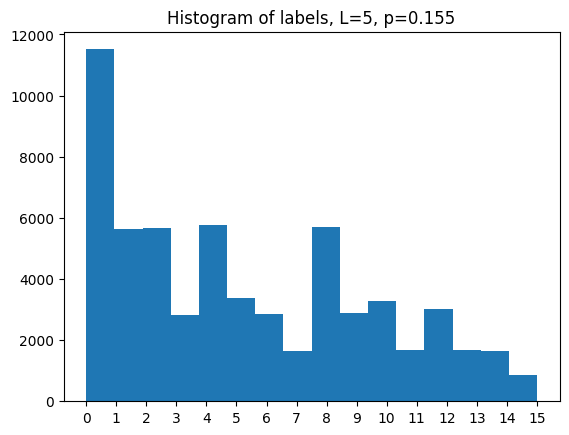

In [5]:
# histogram of nontest_labels_encoded
plt.title(f"Histogram of labels, L={code_distance}, p=0.{error_rate}")
plt.hist(nontest_labels_encoded, bins=16)
# show all x ticks
plt.xticks(np.arange(16))
plt.savefig(f"images/histogram_L_{code_distance}_p_{error_rate}.png")

plt.show()




In [6]:
train_data =  nontest_data
train_labels = nontest_labels_vectorized
test_data = test_data
test_labels = test_labels_vectorized

# create multi-class classifier
model = tf.keras.Sequential([
    tf.keras.layers.Dense(code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.Dense(4*code_distance**2*2, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='softmax')])


In [7]:

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [8]:

# train model
history = model.fit(train_data, train_labels, 
                    epochs=20, 
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/20
47/47 [==============================] - 2s 11ms/step - loss: 0.6210 - accuracy: 0.1275 - val_loss: 0.4839 - val_accuracy: 0.0932
Epoch 2/20
47/47 [==============================] - 0s 7ms/step - loss: 0.3431 - accuracy: 0.1692 - val_loss: 0.2440 - val_accuracy: 0.1875
Epoch 3/20
47/47 [==============================] - 0s 7ms/step - loss: 0.2244 - accuracy: 0.1874 - val_loss: 0.2222 - val_accuracy: 0.1875
Epoch 4/20
47/47 [==============================] - 0s 7ms/step - loss: 0.2113 - accuracy: 0.1969 - val_loss: 0.2213 - val_accuracy: 0.1875
Epoch 5/20
47/47 [==============================] - 0s 7ms/step - loss: 0.2069 - accuracy: 0.2092 - val_loss: 0.2183 - val_accuracy: 0.1875
Epoch 6/20
47/47 [==============================] - 0s 7ms/step - loss: 0.2026 - accuracy: 0.2261 - val_loss: 0.2179 - val_accuracy: 0.1857
Epoch 7/20
47/47 [==============================] - 0s 7ms/step - loss: 0.1982 - accuracy: 0.2455 - val_loss: 0.2134 - val_accuracy: 0.1875
Epoch 8/20
47/47 [=

In [9]:
# evaluate model
model.evaluate(test_data, test_labels, verbose=2)

# print accuracy
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]}")




313/313 - 1s - loss: 0.2030 - accuracy: 0.2812
Accuracy: 0.43927082419395447
Validation accuracy: 0.2864166796207428


In [10]:
labels_pred = model.predict(test_data)

# convert one hot encoded labels back to decimal
labels_pred_dec = np.array([np.argmax(single_label) for single_label in labels_pred])

print(labels_pred_dec[0])


5


Confusion matrix, without normalization


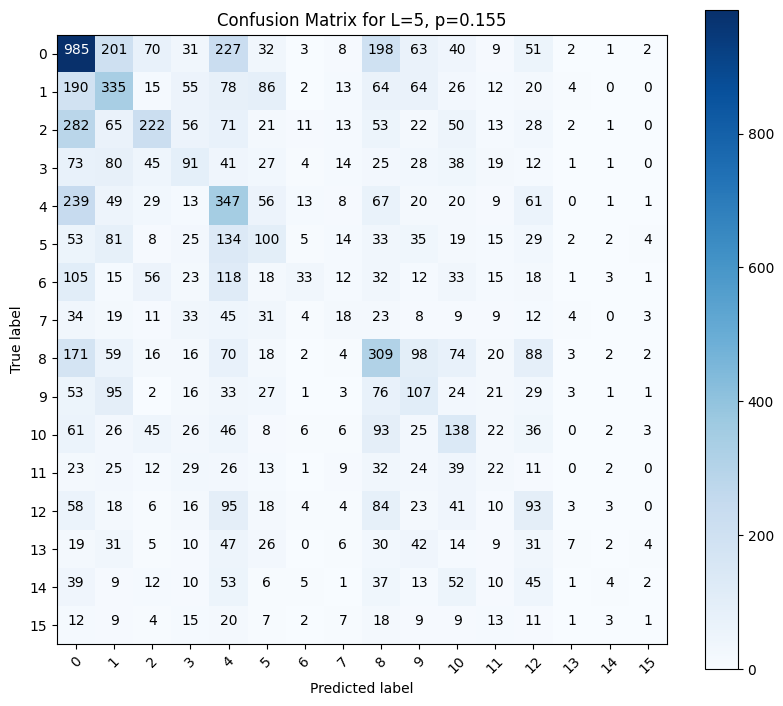

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=f'Confusion Matrix for L={code_distance}, p=0.{error_rate}',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # make bigger
    plt.gcf().set_size_inches(8, 8)

    #plt.savefig(f"cms/cm_L_{code_distance}_p_{error_rate}.png")

    
    plt.show()



cm = confusion_matrix(test_labels_encoded, labels_pred_dec)
plot_confusion_matrix(cm, range(16))

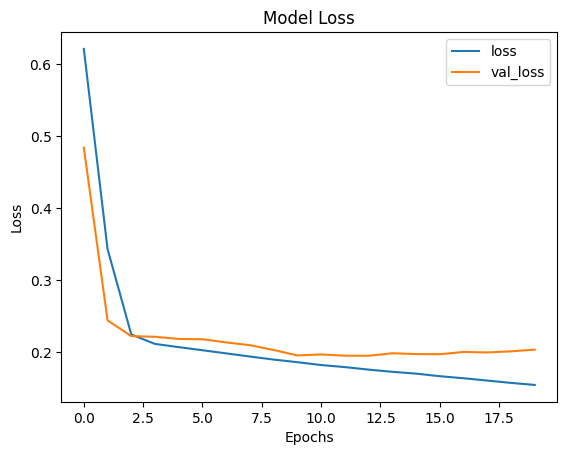

In [12]:
#plot loss and val loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()


In [13]:
# test accuracy
test_accuracy = np.trace(cm) / np.sum(cm)
print(f"Test accuracy: {test_accuracy}")



('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
